## Install packages required for MLFinLab Fork

In [1]:
%%writefile install.sh
pip install numpy==1.17.3
pip install pandas==0.25.3
pip install setuptools==57.5.0
pip install cvxpy==1.0.25
pip install -U llvmlite==0.32.1
pip install git+https://github.com/mhxueshan/mlfinlab
pip install mplfinance==0.12.9b7

Writing install.sh


In [2]:
! bash ./install.sh > install.log 2>&1

In [3]:
! pip list | grep fin

fix-yahoo-finance             0.0.22
mlfinlab                      0.8.0
mplfinance                    0.12.9b7


## Import packages

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import datetime
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from mlfinlab.data_structures import get_ema_tick_imbalance_bars, get_const_tick_imbalance_bars

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

## Generate data using GBM

In [5]:
def gbm(mu, sigma, S0, T, N):
    """
    Generate a Geometric Brownian Motion time series.

    Parameters:
        mu (float): Drift parameter.
        sigma (float): Volatility parameter.
        S0 (float): Initial stock price.
        T (float): Time horizon.
        N (int): Number of time steps.

    Returns:
        ndarray: Array of simulated stock prices.
    """
    # Define time step size
    dt = T / N

    # Generate sequence of random normal variables
    W = np.random.standard_normal(size=N+1)
    W[0] = 0
    W = np.cumsum(W)*np.sqrt(dt)

    # Compute stock prices using GBM formula
    t = np.linspace(0, T, N+1)
    S = S0 * np.exp((mu - 0.5*sigma**2)*t + sigma*W)

    return S

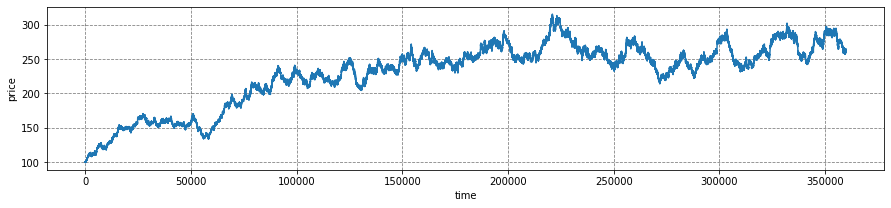

In [6]:
price = gbm(mu=0.15, sigma=0.6, S0=100, T=1, N=3600*100 - 1)

plt.figure(figsize=(15,3))
plt.plot(price)
plt.xlabel('time')
plt.ylabel('price')
plt.grid(linestyle='--', color='k', alpha=0.5)

## Build tick dataframe

In [7]:
ticks = pd.DataFrame(price, columns=['price'])
ticks['tick'] = ticks.index // 1  # 25 Ticks per bar
t0 = datetime.datetime.now().replace(hour=0,minute=0,second=0,microsecond=0)
ticks['Date'] = t0 + ticks['tick'].apply(lambda x: datetime.timedelta(seconds=x))
ticks['Volume'] = 1.0
ticks.tail()

,price,tick,Date,Volume
359995,262.462225,359995,2023-03-03 03:59:55,1.0
359996,262.522584,359996,2023-03-03 03:59:56,1.0
359997,262.214473,359997,2023-03-03 03:59:57,1.0
359998,262.197503,359998,2023-03-03 03:59:58,1.0
359999,261.952613,359999,2023-03-03 03:59:59,1.0


## Time bars

In [8]:
ds = pd.DataFrame(price, columns=['price'])
t0 = datetime.datetime.now().replace(hour=0,minute=0,second=0,microsecond=0)

ds['tick'] = ds.index // 3600  # 3600 Ticks per bar
ds = ds.groupby('tick')['price'].agg(Low='min', High='max', Open='first', Close='last').reset_index()
ds['Date'] = t0 + ds['tick'].apply(lambda x: datetime.timedelta(seconds=3600*x))
ds['Volume'] = 1.0
ds.head()

,tick,Low,High,Open,Close,Date,Volume
0,0,99.853212,114.431523,100.000000,112.767772,2023-02-27 00:00:00,1.0
1,1,110.206822,127.091236,112.872621,125.154260,2023-02-27 01:00:00,1.0
2,2,118.008034,128.277367,125.015023,127.124910,2023-02-27 02:00:00,1.0
3,3,126.212909,141.325688,127.187338,138.458973,2023-02-27 03:00:00,1.0
4,4,137.223192,154.422000,138.306817,146.452619,2023-02-27 04:00:00,1.0


## Build imbalance bars 

In [9]:
ts = ticks[['Date', 'price', 'Volume']]
bars, th = get_const_tick_imbalance_bars(ts, expected_imbalance_window=1000, exp_num_ticks_init=2000, verbose=True)

imbalance_bars = bars[['date_time', 'open', 'high', 'low', 'close','volume']].rename(columns={
    'date_time':'Date',
    'open':'Open',
    'high':'High',
    'low':'Low',
    'close':'Close',
    'volume':'Volume',
}).set_index('Date')

Reading data in batches:
Batch number: 0
Returning bars 



## Plot bars

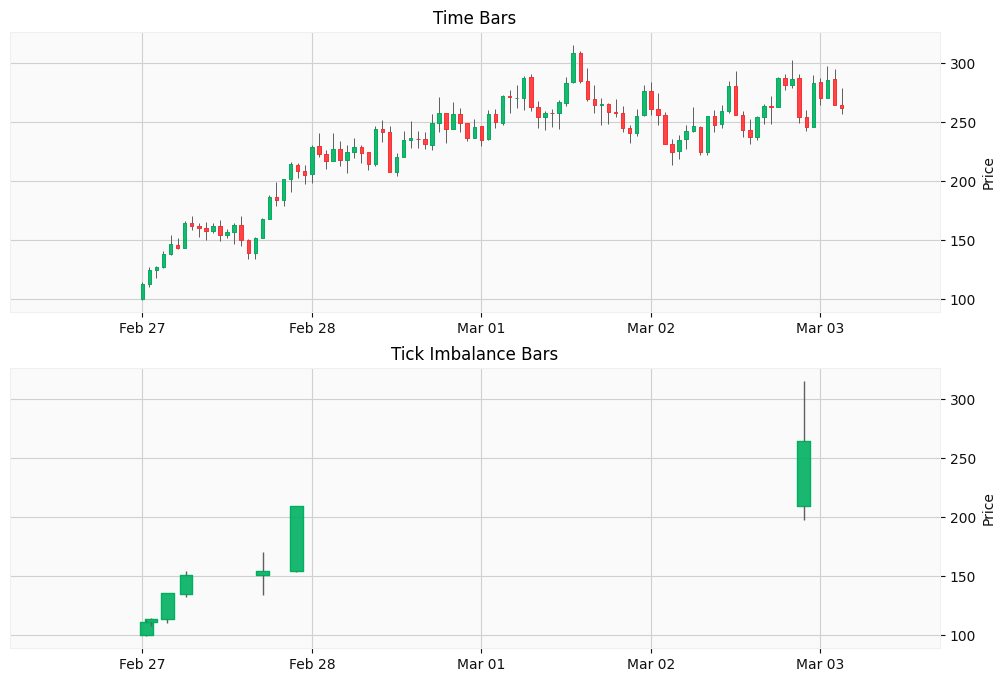

In [10]:
time_bars = ds[['Date', 'Open', 'High', 'Low', 'Close']].set_index('Date')

fig = mpf.figure(style='yahoo', figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)

mpf.plot(time_bars, type='candle', ax=ax1, axtitle='Time Bars', xrotation=0, show_nontrading=True)
mpf.plot(imbalance_bars.sort_index(), type='candle', ax=ax2, axtitle='Tick Imbalance Bars', xrotation=0, scale_width_adjustment=dict(candle=0.2), show_nontrading=True)

fig.patch.set_facecolor('white')

## References
1.   Matplotlib Developers, [Financial Markets Data Visualization using Matplotlib](https://github.com/matplotlib/mplfinance), GitHub, 2019-2023. 
1.   Hudson and Thames Quantitative Research, [Machine Learning Financial Laboratory](https://github.com/hudson-and-thames/mlfinlab), GitHub, 2021.
1.   雪山(bryce), [mlfinlab modifyfied by Bryce](https://github.com/mhxueshan/mlfinlab), GitHub, 2019-2020.
2.   Yong Hong Tan, [Plot Stock Chart Using mplfinance in Python (An introductory guide to plot a candlestick chart along with volume, MACD & stochastic using mplfinance)](https://python.plainenglish.io/plot-stock-chart-using-mplfinance-in-python-9286fc69689) , Python in Plain English, 2022.
4.   Denny Joseph, [Imbalance bars](https://medium.com/@quant_views/imbalance-bars-a860a97838b2), Medium, 2021
3.   Maks Ivanov, [Financial Machine Learning Part 0: Bars](https://medium.com/towards-data-science/financial-machine-learning-part-0-bars-745897d4e4ba), Towards Data Science, 2019
5.   Gerard Martínez, [Information-driven bars for financial machine learning: imbalance bars](https://towardsdatascience.com/information-driven-bars-for-financial-machine-learning-imbalance-bars-dda9233058f0), Towards Data Science, 2019

